*This notebook was adapted from [here](https://github.com/rmassei/2024-jn-omero-pipeline), with thanks to the original author Riccardo Massei.*

# Workflow from OMERO - Cell Nuclei Segmentation

The present jupyter notebook shows an automatic pipeline to fetch data from OMERO, perform several processing steps and push back the results OMERO adding potential metadata and Region of Interest (ROIs).

## 1) Import Packages

In [35]:
import getpass

import ezomero
import pandas as pd
import tifffile
import numpy as np

from skimage import filters, morphology, measure
from skimage.color import label2rgb
from matplotlib import pyplot as plt

## 2) Set Parameters to login into OMERO

Add here your username or password. Adjust the OMERO host and port accordingly.

In [37]:
OMEROUSER = input(f"Enter username: \t")
OMEROPASS = getpass.getpass(prompt = f"Enter password: \t")
OMEROGROUP = "workshop_2025"
OMEROHOST = "141.76.16.87"
OMEROPORT = 4064

## 3) Connect to OMERO

In [38]:
# Connection Check:
conn=ezomero.connect(user=OMEROUSER, 
                     password=OMEROPASS, 
                     group=OMEROGROUP, 
                     host=OMEROHOST, 
                     port=OMEROPORT, 
                     secure=True)

In [39]:
## Information about the connection and its status
print(conn.isConnected())
user = conn.getUser()
print("Current user:")
print("   ID:", user.getId())
print("   Username:", user.getName())
print("   Full Name:", user.getFullName())

True
Current user:
   ID: 203
   Username: mazo260d
   Full Name: Marcelo Leomil Zoccoler


## 4) Browse your OMERO project folder

Browse your project and have an overview on the project and their content

In [40]:
proj_ids = ezomero.get_project_ids(conn)
print("Current Project IDs: {proj_ids}".format(proj_ids=proj_ids))

Current Project IDs: [205, 202, 203, 204]


In [41]:
project_id = 205

In [47]:
ds_ids = ezomero.get_dataset_ids(conn, project=project_id)
print("Current Dataset IDs: {ds_ids}".format(ds_ids=ds_ids))

Current Dataset IDs: [313]


In [48]:
dataset_id = 313

In [49]:
img_ids = ezomero.get_image_ids(conn, dataset=dataset_id)
print("Current Image IDs: {img_ids}".format(img_ids=img_ids))

Current Image IDs: [4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504]


In [50]:
img_id = ezomero.filter_by_filename(conn,
                                    img_ids,
                                    imported_filename="image85-H-01-00.tif")[0]
print(img_id)

4496


### 4.1) Select your image

Read image object and image pixel data. Check more options in the [ezomero.get_image documentation](https://thejacksonlaboratory.github.io/ezomero/ezomero.html#ezomero.get_image).

In [52]:
img_obj, image = ezomero.get_image(conn, image_id=img_id)

### 4.2) Get information about your image

In [53]:
print("Image name: ", img_obj.getName(), img_obj.getDescription())
# Retrieve information about an image.
print("Image shape (TZYXC):", image.shape)
# List Channels (loads the Rendering settings to get channel colors)
for channel in img_obj.getChannels():
    print ('Channel:', channel.getLabel(),)
    print ('Color:', channel.getColor().getRGB())
    print ('Lookup table:', channel.getLut())

Image name:  image85-H-01-00.tif 
Image shape (TZYXC): (1, 1, 1024, 1360, 1)
Channel: 0
Color: (128, 128, 128)
Lookup table: None


### 4.3) Plot your images

In [54]:
# Remove unitary dimensions
nuclei = np.squeeze(image)
print("Image shape:", nuclei.shape)

Image shape: (1024, 1360)


Text(0.5, 1.0, 'image85-H-01-00.tif')

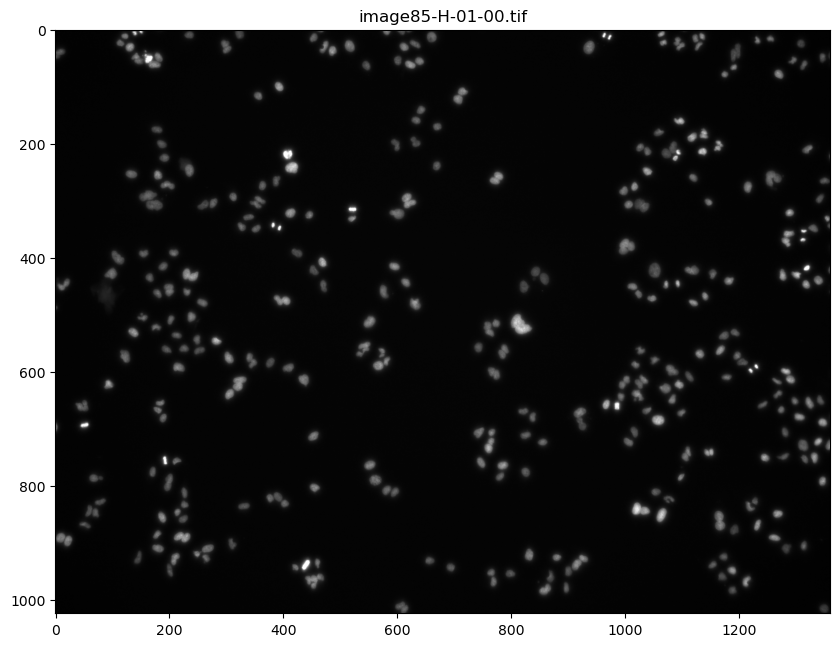

In [55]:
fig, axs = plt.subplots(1,1, figsize=(10,10))
axs.imshow(nuclei, cmap='gray')
axs.set_title(f'{img_obj.getName()}')

## 5) Image Processing 1 - Denoising

Apply a gaussian filter to denoise

Text(0.5, 1.0, 'Nuclei - Processed')

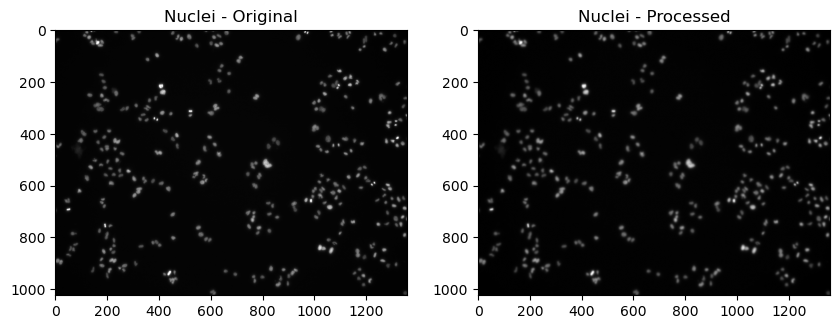

In [56]:
nuclei_gaussian = filters.gaussian(image=nuclei,
                                   sigma=2)

fig, axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(nuclei, cmap='gray')
axs[0].set_title('Nuclei - Original')
axs[1].imshow(nuclei_gaussian, cmap='gray')
axs[1].set_title('Nuclei - Processed')

## 6) Image Processing 2 - Binarization and Labelling

Apply a OTSU threshold and create the labelling

Text(0.5, 1.0, 'Labels')

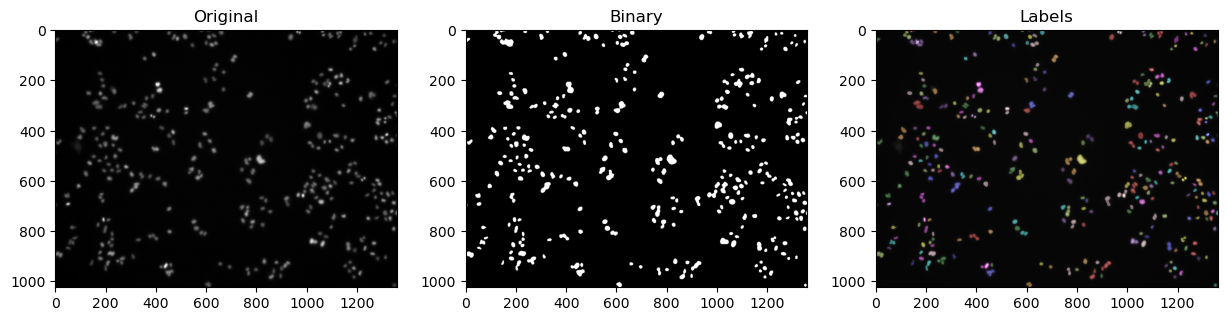

In [57]:
# Create a disk with radius = 3
disk = morphology.disk(radius=3)

# Apply Otsu thresholding
threshold = filters.threshold_otsu(nuclei_gaussian)
binary_image = nuclei_gaussian >= threshold

# Apply binary opening
opened = morphology.binary_opening(image=binary_image,
                                    footprint=disk)

# Label nuclei
labeled_nuclei = measure.label(opened)

# Remove small objects
cleaned = morphology.remove_small_objects(ar=labeled_nuclei, 
                                          min_size=50)

# Create overlay
image_label_overlay = label2rgb(label=cleaned,
                                image=nuclei,
                                bg_label=0)

fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(nuclei_gaussian, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(binary_image, cmap='gray')
axs[1].set_title('Binary')
axs[2].imshow(image_label_overlay)
axs[2].set_title('Labels')

Save the labelled image locally as a TIFF file (optional)

In [59]:
tifffile.imwrite('test.tif', 
                 data=cleaned, 
                 dtype=cleaned.dtype, 
                 shape=cleaned.shape)

## 7) Extract table with features

In [60]:
properties = ['label', 'area', 'mean_intensity', 'major_axis_length', 'minor_axis_length']
features = measure.regionprops_table(label_image=cleaned,
                                       intensity_image=nuclei,
                                       properties=properties)
df = pd.DataFrame(features)
df

,label,area,mean_intensity,major_axis_length,minor_axis_length
0,1,228.0,100.776316,23.950503,12.645780
1,2,68.0,75.691176,14.067066,6.417968
2,3,145.0,96.379310,16.540009,11.641556
3,4,167.0,73.101796,25.990490,9.497349
4,5,152.0,67.394737,15.392008,12.589055
...,...,...,...,...,...
273,274,252.0,93.837302,22.044799,14.757864
274,275,133.0,75.947368,16.930923,10.022112
275,276,118.0,69.949153,12.265426,12.236114
276,277,314.0,78.235669,22.706386,17.872958


Save table locally as a CSV file (optional)

In [61]:
df.to_csv("feature_extraction.csv")

## 8) Push back the results to OMERO and add metadata plus other information

Make image 5D for importing into OMERO

In [62]:
labelled_nuclei = cleaned[np.newaxis, np.newaxis, :, :, np.newaxis] # tzyxc
print("Labels new shape (TZYXC):", labelled_nuclei.shape)

Labels new shape (TZYXC): (1, 1, 1024, 1360, 1)


In [63]:
## Create a new dataset
new_dataset_id = ezomero.post_dataset(conn, 
                                      dataset_name="Processed", 
                                      project_id=project_id)
# Push image to new dataset
new_image_id = ezomero.post_image(conn, 
                                  image=labelled_nuclei, 
                                  image_name="labelled_nuclei", 
                                  dataset_id=new_dataset_id, 
                                  dim_order='tzyxc')

### 8.1) Add key-value pairs as annotations

In [64]:
kv_pairs = {
    "Analysis Result Type" : "Processed",
    "Data Used for The Analysis": f"{img_obj.getName()}",
    "Analysis method and details" : "Skimage"
}

map_ann_id = ezomero.post_map_annotation(conn, 
                                         object_type="Image", 
                                         object_id=new_image_id, 
                                         kv_dict=kv_pairs, 
                                         ns="REMBI_Analyzed")
# To update an existing map annotation, use
# ezomero.put_map_annotation(conn,
#                            map_ann_id=map_ann_id,
#                            kv_dict=kv_pairs,
#                            ns="REMBI_Analyzed")

object group 154


### 8.2) Add description and table with the results

In [65]:
# Update existing description
ezomero.put_description(conn,
                        obj_type='Image',
                        obj_id=new_image_id,
                        desc="This Image Was Created")
# Post table
table_id = ezomero.post_table(conn, 
                              table=df, 
                              object_type="Image",
                              object_id=new_image_id,
                              title='Features Results',
                              headers=True) # this uploads the file, but it cannot be viewed or downloaded properly in OMERO Insight, only in OMERO web with omero table

## 9) Close Connection

Run the cell below to properly close the connection to OMERO. If you need to re-open it, connect again by running the [3) Connect to OMERO](#3_connect_to_omero)-cell.

In [34]:
conn.close()

## 10) OPTIONAL - Add masks as ROIs

Add the labelling directly as ROIs in OMERO with ezomero

In [66]:
from cmap import Colormap

glasbey_cm = Colormap('glasbey:glasbey') 

In [85]:
properties = measure.regionprops(cleaned)

shapes = list()
for prop in properties:
    coords = prop.coords
    coords_xy = coords.astype(float)
    coords_xy = coords[:, [1, 0]].astype(float)  # Swap columns and convert to float
    coords_xy_tuples = [(x, y) for x, y in coords_xy]
    polygon = ezomero.rois.Polygon(points=coords_xy_tuples, 
                                   label=str(prop.label), 
                                   z=0, 
                                   c=0, 
                                   t=0, 
                                   fill_color=tuple(list(map(int, glasbey_cm(prop.label).rgba8))[:-1] + [255]),
                                   stroke_color=tuple(list(map(int, glasbey_cm(prop.label).rgba8))[:-1] + [255]))
    shapes.append(polygon)

In [86]:
rois_id = ezomero.post_roi(conn, 
                           image_id=new_image_id, 
                           shapes=shapes, 
                           name='Nuclei Segmentation') # this does not display properly in OMERO Insight, only in OMERO web

# Automatize the pipeline trought a dataset on OMERO

In [87]:
dataset = conn.getObject("Dataset", dataset_id)

ID =[]

for images in dataset.listChildren():
    ID.append(images.getId())

print(ID)

for id in ID:
    img = conn.getObject("Image", id)
    ### repeat the pipeline ###

[4496, 4497, 4498, 4499, 4500, 4501, 4502, 4503, 4504]
